# Bitcoin Price Prediction using Linear Regression: A Complete Implementation

This tutorial demonstrates how to implement linear regression from scratch to predict Bitcoin prices. We'll walk through data preprocessing, feature engineering, and implementing gradient descent optimization.

## Table of Contents
1. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
3. [Feature Engineering](#feature-engineering)
4. [Mathematical Foundation](#mathematical-foundation)
5. [Implementation from Scratch](#implementation-from-scratch)
6. [Model Training](#model-training)
7. [Results and Analysis](#results-and-analysis)

# Data Loading and Preprocessing

#### First, let's import the necessary libraries and load our Bitcoin price data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#### Load the Bitcoin historical data

In [2]:
dataset_url = 'https://raw.githubusercontent.com/pvcodes/ml/refs/heads/main/dataset/BTC-USD_stock_data.csv' if os.getenv("COLAB_RELEASE_TAG") else 'dataset/BTC-USD_stock_data.csv'
df = pd.read_csv(dataset_url)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


### Data Standardization

To ensure our gradient descent algorithm converges efficiently, we standardize all features using z-score normalization:

**Why standardization matters:**
- Features with different scales can dominate the learning process
- Standardization ensures equal contribution from all features
- Improves convergence speed of gradient descent


In [3]:
# Standardize the data using z-score normalization
df = (df - df.mean()) / df.std(ddof=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,-1.127270,-1.127174,-1.126278,-1.126117,-1.126117,-1.203614
2017-01-02,-1.125501,-1.125773,-1.124308,-1.124932,-1.124932,-1.199674
2017-01-03,-1.124338,-1.125144,-1.123017,-1.123815,-1.123815,-1.201634
2017-01-04,-1.123185,-1.119433,-1.121835,-1.118206,-1.118206,-1.193174
2017-01-05,-1.117501,-1.117865,-1.128781,-1.125355,-1.125355,-1.184423


# Exploratory Data Analysis

### Visualizing Bitcoin Price Trends

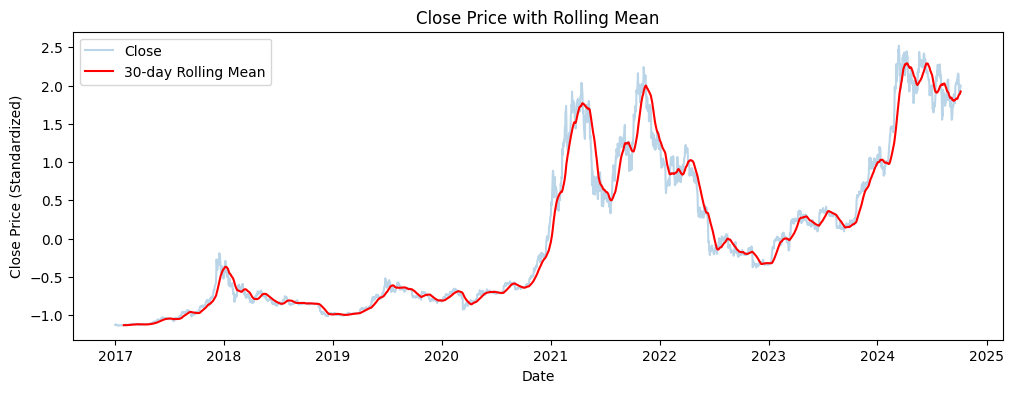

In [4]:
rolling = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(12,4))
plt.plot(df.index, df['Close'], alpha=0.3, label='Close')
plt.plot(df.index, rolling, color='red', label='30-day Rolling Mean')
plt.title('Close Price with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Close Price (Standardized)')
plt.legend()
plt.show()

## Feature Engineering
### Creating Target Variable
We create our target variable by shifting the closing price one day forward:

In [5]:
# Create target variable (next day's closing price)
df['Target'] = df['Close'].shift(-1)
df['Target'] = df['Target'].fillna(df['Target'].mean())

### Preparing Feature Matrix


In [6]:
# Separate features and target
features = df.loc[:, ~df.columns.isin(['Target', 'Adj Close', 'Close'])]
target = df['Target']
print(f'Feature matrix shape: {features.shape}')
print(f'Target vector shape: {target.shape}')

Feature matrix shape: (2836, 4)
Target vector shape: (2836,)


## Mathematical Foundation

### Linear Regression Model

Our linear regression model predicts the target variable using a linear combination of input features:

$$\hat{y} = \mathbf{w}^T\mathbf{x} + b$$

Where:
- $\hat{y}$ is the predicted value
- $\mathbf{w}$ is the weight vector
- $\mathbf{x}$ is the feature vector
- $b$ is the bias term

### Cost Function (Mean Squared Error)

The cost function measures how well our model fits the data:

$$J(\mathbf{w}, b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$$

Where:
- $m$ is the number of training examples
- $\hat{y}^{(i)}$ is the prediction for the $i$-th example
- $y^{(i)}$ is the actual value for the $i$-th example

### Gradient Descent Update Rules

To minimize the cost function, we use gradient descent with these update rules:

$$\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) \cdot x_j^{(i)}$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})$$

Parameter updates:
- $w_j := w_j - \alpha \frac{\partial J}{\partial w_j}$
- $b := b - \alpha \frac{\partial J}{\partial b}$

Where $\alpha$ is the learning rate.


## Let's Implement our Model

### 1. Model Function

In [7]:
def model_fn(X, w, b):
    """
    Linear regression prediction function.
    
    Args:
        X: Feature matrix (m x n)
        w: Weight vector (n,)
        b: Bias scalar
    
    Returns:
        y_hat: Predicted values (m,)
    """
    y_hat = np.dot(X, w) + b
    return y_hat

### 2. Cost Function


In [8]:
def cost_fn(X, Y, w, b):
    """
    Calculate Mean Squared Error cost.
    
    Args:
        X: Feature matrix
        Y: Target vector
        w: Weight vector
        b: Bias scalar
    
    Returns:
        cost: Mean squared error
    """
    m = len(X)
    y_hat = model_fn(X, w, b)
    cost = np.sum((y_hat - Y) ** 2) / (2 * m)
    return cost

### 3. Gradient Computation


In [9]:
def compute_gradient(X, Y, w, b):
    """
    Compute gradients for weights and bias.
    
    Args:
        X: Feature matrix
        Y: Target vector
        w: Weight vector
        b: Bias scalar
    
    Returns:
        dl_dw: Gradient with respect to weights
        dl_db: Gradient with respect to bias
    """
    m = len(X)
    y_hat = model_fn(X, w, b)
    
    # Compute gradients
    dl_dw = np.dot(X.T, (y_hat - Y)) / m
    dl_db = np.sum(y_hat - Y) / m
    
    return dl_dw, dl_db

### 4. Gradient Descent Algorithm


In [10]:
def gradient_descent(X, Y, w_init, b_init, alpha, iterations):
    """
    Optimize weights and bias using gradient descent.
    
    Args:
        X: Feature matrix
        Y: Target vector
        w_init: Initial weights
        b_init: Initial bias
        alpha: Learning rate
        iterations: Number of iterations
    
    Returns:
        w: Optimized weights
        b: Optimized bias
        cost_hist: Cost history
    """
    w = w_init.copy()
    b = b_init
    cost_hist = []
    
    for i in range(iterations):
        # Compute gradients
        dl_dw, dl_db = compute_gradient(X, Y, w, b)
        
        # Update parameters
        w = w - alpha * dl_dw
        b = b - alpha * dl_db
        
        # Track cost
        cost = cost_fn(X, Y, w, b)
        cost_hist.append(cost)
        
        # Print progress
        if i % 1000 == 0:
            print(f"Iteration {i:4d}: Cost = {cost:.6f}")
    
    return w, b, cost_hist

## Model Training

### Training the Model



In [11]:
# Convert to numpy arrays for efficient computation
X_train = features.to_numpy()
y_train = target.to_numpy()
print(X_train[0].shape)
# Initialize parameters
w_init = np.zeros_like(X_train[0])
b_init = 0.0

# Hyperparameters
alpha = 0.003      # Learning rate
iterations = 10000

# Train the model
print("Training Linear Regression Model...")
w_final, b_final, cost_history = gradient_descent(
    X_train, y_train, w_init, b_init, alpha, iterations
)

print(f"\nFinal parameters:")
print(f"Weights: {w_final}")
print(f"Bias: {b_final:.6f}")
print(f"Final cost: {cost_history[-1]:.6f}")

(4,)
Training Linear Regression Model...
Iteration    0: Cost = 0.490054
Iteration 1000: Cost = 0.002747
Iteration 2000: Cost = 0.002477
Iteration 3000: Cost = 0.002471
Iteration 4000: Cost = 0.002470
Iteration 5000: Cost = 0.002469
Iteration 6000: Cost = 0.002468
Iteration 7000: Cost = 0.002467
Iteration 8000: Cost = 0.002466
Iteration 9000: Cost = 0.002465

Final parameters:
Weights: [0.3171966  0.33803909 0.34089733 0.00278552]
Bias: 0.000397
Final cost: 0.002464


### Visualizing Training Progress


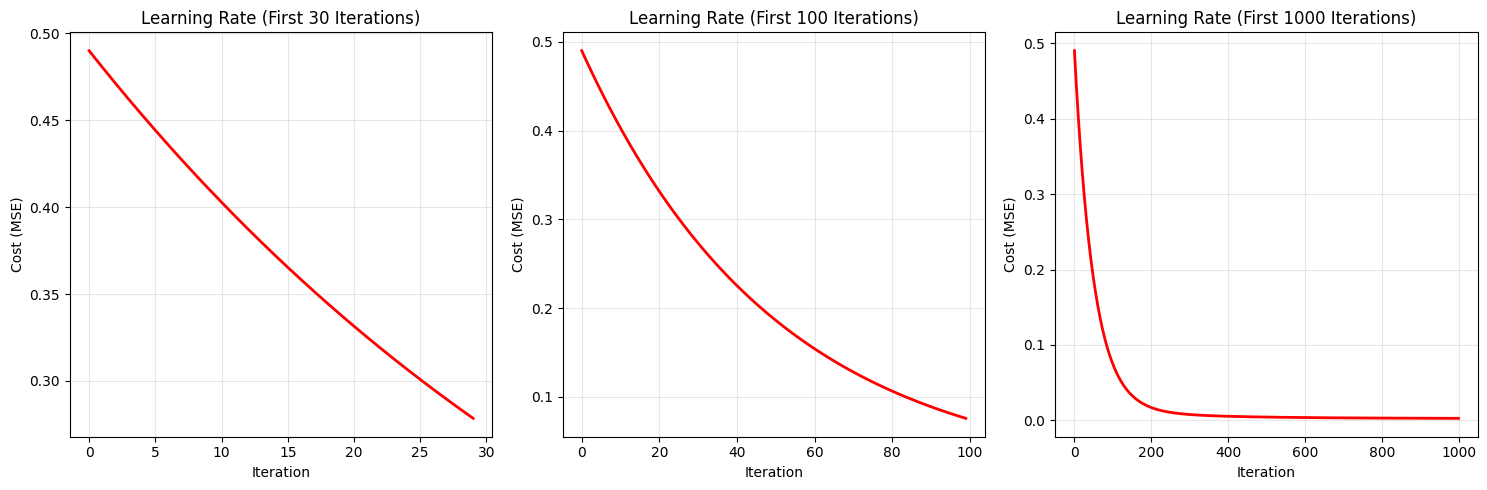

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(cost_history[:30], linewidth=2, color='red')
plt.title('Learning Rate (First 30 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(cost_history[:100], linewidth=2, color='red')
plt.title('Learning Rate (First 100 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(cost_history[:1000], linewidth=2, color='red')
plt.title('Learning Rate (First 1000 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Results and Analysis

#### R-Squared Score
R-Squared Score measures the proportion of variance in the dependent variable explained by the independent variable(s) in a regression model. It signifies how well the model fits the data, with values closer to 1 indicating a better fit.

In [13]:
# Make predictions on the training data
y_pred = model_fn(X_train, w_final, b_final)

# Calculate R-squared score
ss_res = np.sum((y_train - y_pred) ** 2)
ss_tot = np.sum((y_train - np.mean(y_train)) ** 2)
r2_score = 1 - (ss_res / ss_tot)

print(f"R-squared Score: {r2_score:.4f}")

R-squared Score: 0.9951


### Prediction vs Actual Plot


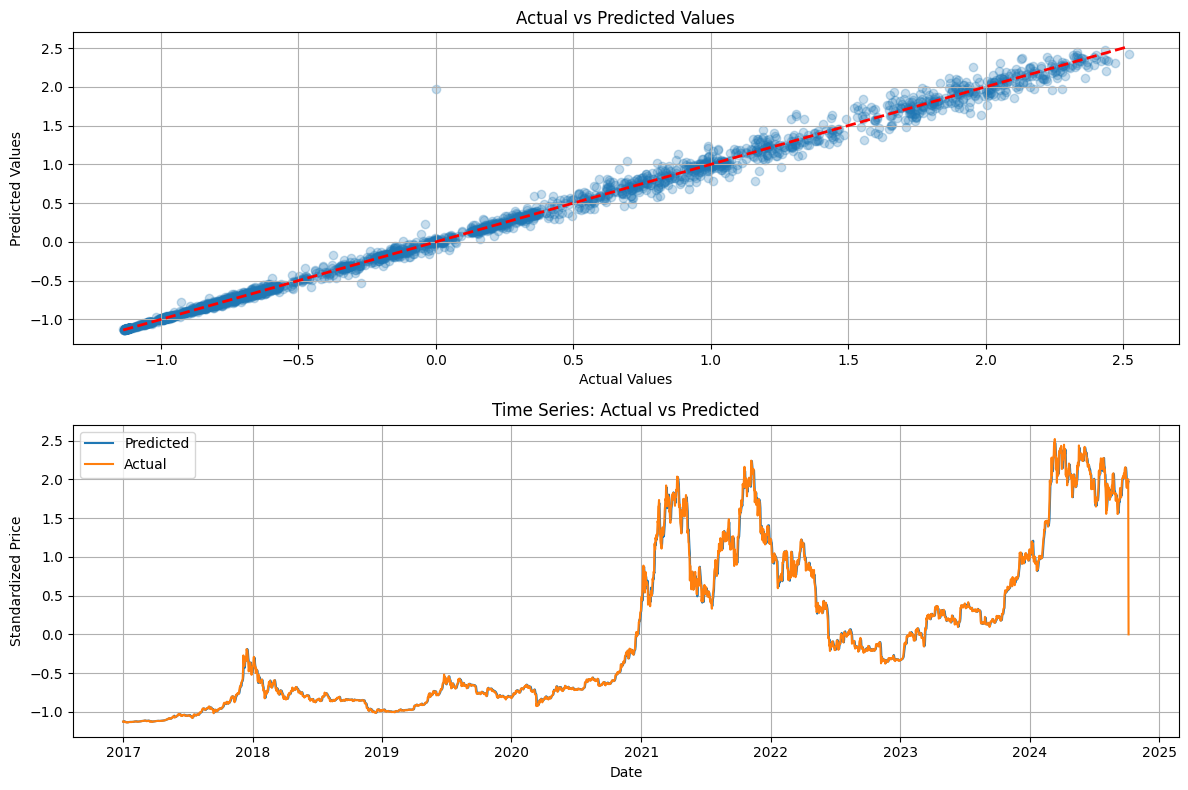

In [14]:
plt.figure(figsize=(12, 8))

# Scatter plot
plt.subplot(2, 1, 1)
plt.scatter(y_train, y_pred, alpha=0.25)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)

# Time series plot
plt.subplot(2, 1, 2)
plt.plot(df.index[:len(y_pred)], y_pred, label='Predicted')
plt.plot(df.index[:len(y_train)], y_train, label='Actual')
plt.xlabel('Date')
plt.ylabel('Standardized Price')
plt.title('Time Series: Actual vs Predicted')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Feature Importance Analysis


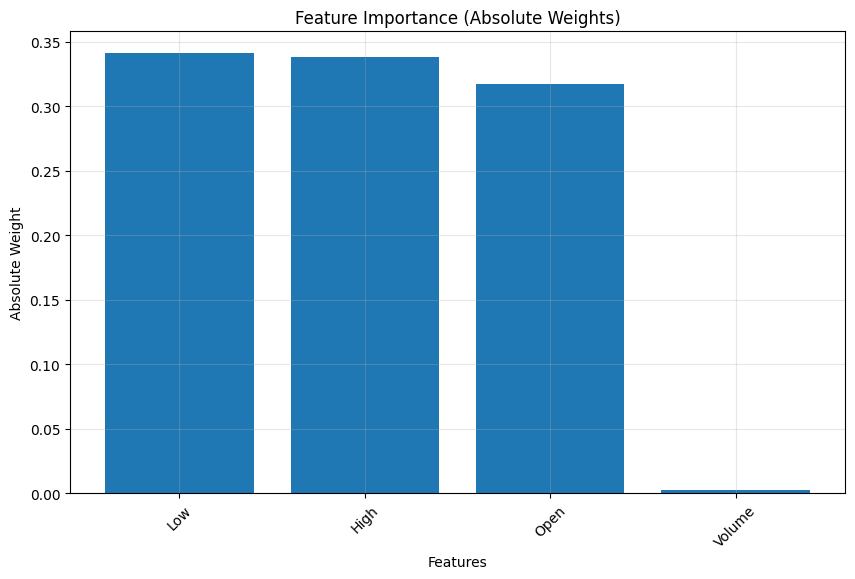

In [15]:
# Analyze feature importance based on absolute weights
feature_names = features.columns
importance = np.abs(w_final)
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[indices])
plt.xlabel('Features')
plt.ylabel('Absolute Weight')
plt.title('Feature Importance (Absolute Weights)')
plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
plt.grid(True, alpha=0.3)
plt.show()


## Key Takeaways

### Model Performance Insights
1. **Convergence**: The cost function should decrease monotonically, indicating successful optimization
2. **R-squared Score**: Measures the proportion of variance explained by the model
3. **Feature Importance**: Higher absolute weights indicate more influential features

### Implementation Benefits
- **From-Scratch Understanding**: Building gradient descent from scratch provides deep insights into optimization
- **Mathematical Foundation**: Understanding the underlying mathematics improves model intuition
- **Customization**: Full control over the algorithm allows for custom modifications

### Potential Improvements
1. **Feature Engineering**: Add technical indicators (RSI, MACD, Bollinger Bands)
2. **Regularization**: Implement L1/L2 regularization to prevent overfitting
3. **Cross-Validation**: Use time-series cross-validation for more robust evaluation
4. **Advanced Models**: Consider polynomial features or neural networks for non-linear patterns

## Mathematical Appendix

### Vectorized Implementation

The gradient computation can be efficiently vectorized:

$$\nabla_{\mathbf{w}} J = \frac{1}{m} \mathbf{X}^T (\mathbf{X}\mathbf{w} + b\mathbf{1} - \mathbf{y})$$

$$\nabla_b J = \frac{1}{m} \mathbf{1}^T (\mathbf{X}\mathbf{w} + b\mathbf{1} - \mathbf{y})$$

Where $\mathbf{1}$ is a vector of ones.

### Learning Rate Selection

The learning rate $\alpha$ is crucial for convergence:
- Too large: May overshoot the minimum
- Too small: Slow convergence
- Adaptive methods like Adam can automatically adjust the learning rate

This implementation provides a solid foundation for understanding linear regression and can be extended for more complex financial prediction tasks.